In [1]:
%load_ext autoreload
%autoreload 2

import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from split import Splitter
from credentials import Credentials as cr
from functions import Functions as fc

spl = Splitter()

In [2]:
# Split des données sur l'année
# spl.split_datas_keys(cr.DATA_TRAIN, 'train')
# spl.split_datas_keys(cr.DATA_TEST, 'test')

In [2]:
# Import en DF des données splittées : on s'intéresse aux données de 2015
train_set = pd.read_csv(cr.CURATED_TRAIN + "2015.csv", sep=",")
test_set = pd.read_csv(cr.CURATED_TEST + "2015.csv", sep=",")

In [3]:
print("-------- TRAIN_SET -------")
train_set.info()
print("\n\n-------- TEST_SET -------")
test_set.info()

-------- TRAIN_SET -------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3856809 entries, 0 to 3856808
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float64
 4   pickup_latitude    float64
 5   dropoff_longitude  float64
 6   dropoff_latitude   float64
 7   passenger_count    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 235.4+ MB


-------- TEST_SET -------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619 entries, 0 to 618
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                619 non-null    object 
 1   pickup_datetime    619 non-null    object 
 2   pickup_longitude   619 non-null    float64
 3   pickup_latitude    619 non-null    float64
 4   dropoff_longitude  619 non-null    float64
 5   drop

In [3]:
# Premières vérifications des valeurs : 
nancount = test_set['passenger_count'].isna()
print("Nombre de lignes 'passenger_count' nulles dans le dataset de test : ", nancount.sum())
nancount = train_set['passenger_count'].isna()
print("Nombre de lignes 'passenger_count' nulles dans le dataset de train : ", nancount.sum())
num_nuls = test_set[test_set['passenger_count']<=0]
print('Nombre de trajets avec 0 passagers dans le dataset test : ', len(num_nuls))
num_nuls = train_set[train_set['passenger_count']<=0]
print('Nombre de trajets avec 0 passagers dans le dataset train : ', len(num_nuls))
num_nuls = train_set[train_set['fare_amount']<=0]
print('Nombre de trajets avec "fare_amount" <= 0 dans le dataset train : ', len(num_nuls))

Nombre de lignes 'passenger_count' nulles dans le dataset de test :  0
Nombre de lignes 'passenger_count' nulles dans le dataset de train :  0
Nombre de trajets avec 0 passagers dans le dataset test :  0
Nombre de trajets avec 0 passagers dans le dataset train :  1802
Nombre de trajets avec "fare_amount" <= 0 dans le dataset train :  2231


In [4]:
# Filtrage sur le nombre de passagers
filtered_train_set = train_set[train_set['passenger_count']>=1]
filtered_train_set = train_set[train_set['fare_amount']>=1]

array([[<AxesSubplot:title={'center':'passenger_count'}>]], dtype=object)

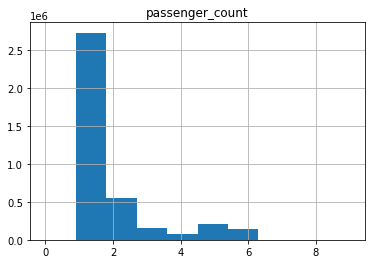

In [4]:
filtered_train_set.hist(column='passenger_count')

In [5]:
# Ajout colonne distance parcourue en Km avec la fonction compute_distance
filtered_train_set = filtered_train_set.assign(distance_km=fc.compute_distance(filtered_train_set['pickup_latitude'], filtered_train_set['pickup_longitude'], filtered_train_set['dropoff_latitude'], filtered_train_set['dropoff_longitude']))

In [6]:
# Sélection des colonnes qui intéressent et reformatage de la distance (stressant)
filtered_train_set = filtered_train_set[['passenger_count', 'distance_km', 'fare_amount']]
filtered_train_set.distance_km = filtered_train_set.distance_km.map('{:.2f}'.format)

In [6]:
# Ajout colonne prix moyen/Km
# filtered_train_set = filtered_train_set.assign(prix_km=(filtered_train_set['fare_amount']/filtered_train_set['distance_km']).map('{:.0f}'.format))

In [7]:
filtered_train_set.head()

,passenger_count,distance_km,fare_amount
0,1,6.71,22.54
1,1,12.79,58.00
2,1,0.81,4.50
3,6,3.38,11.50
4,1,0.84,5.00


In [8]:
# Sauvegarde du premier DF filtré
filtered_train_set.to_csv(cr.CURATED_PATH + 'filtered_train_set.csv')

In [21]:
# Isolation Forest pour détecter les naomalies
fc.isolation_forest(cr.CURATED_PATH + 'filtered_train_set.csv', cr.CURATED_PATH + 'IFScore.csv')

   Unnamed: 0  passenger_count  distance_km  fare_amount    scores  anomaly
0           0                1         6.71        22.54 -0.007230       -1
1           1                1        12.79        58.00 -0.082405       -1
2           2                1         0.81         4.50  0.046305        1
3           3                6         3.38        11.50 -0.006841       -1
4           4                1         0.84         5.00  0.052302        1
5           5                2         0.59         5.00  0.015541        1
6           6                2         1.99        11.00  0.044893        1
7           7                1         3.50        14.00  0.028639        1
8           8                3         6.37        16.50 -0.032511       -1
9           9                1         2.90         9.00  0.063852        1


In [26]:
filtered_train_set_with_IF = pd.read_csv(cr.CURATED_PATH + 'IFScore.csv', usecols=['passenger_count', 'distance_km', 'fare_amount', 'scores', 'anomaly'])
filtered_train_set_with_IF.head()

,passenger_count,distance_km,fare_amount,scores,anomaly
0,1,6.71,22.54,-0.007230,-1
1,1,12.79,58.00,-0.082405,-1
2,1,0.81,4.50,0.046305,1
3,6,3.38,11.50,-0.006841,-1
4,1,0.84,5.00,0.052302,1


In [28]:
print("filtered_train_set_with_IF ", len(filtered_train_set_with_IF), " rows")
print("Anomalies ", len(filtered_train_set_with_IF[filtered_train_set_with_IF['anomaly']==-1]), " rows")

filtered_train_set_with_IF  3854148  rows
Anomalies  805757  rows


In [29]:
filtered_train_set_with_IF = filtered_train_set_with_IF[['passenger_count', 'distance_km', 'fare_amount']][filtered_train_set_with_IF["anomaly"] != -1]

<AxesSubplot:>

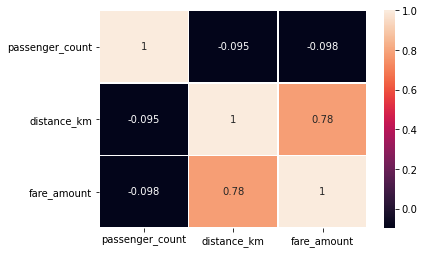

In [30]:
data_corr_train = filtered_train_set_with_IF.corr()
sns.heatmap(data_corr_train, linewidths=.5, annot=True)

In [8]:
# # read in data
# dtrain = xgb.DMatrix(filtered_train_set)
# dtest = xgb.DMatrix(filtered_test_set)

# # specify parameters via map
# param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
# num_round = 2
# bst = xgb.train(param, dtrain, num_round)

# # make prediction
# preds = bst.predict(dtest)